# **Question 1**
## Find the largest number from a list

In [1]:
# Create a user defined function to find the largest number among a list's elements
def largest(my_list):
  for i in range(len(my_list)):
    if i == 0:
      x = my_list[0]
    elif my_list[i] > my_list[i-1]:
      x = my_list[i]
  return x

print(largest([1, 2, 3]))
print(largest([4, 2, 6, 4, 3, 9, 5]))

3
9


# **Question 2**
## Inheritance - add a property (`matric_no`) to the `Student` class

In [2]:
# Method 1

# Create the parent class called Person with two properties (name and age)
class Person():
  def __init__(self, name, age):
    self.name = name
    self.age = age  
  def display(self):
    print("Name:", self.name)
    print("Age:", self.age)

  def __str__(self):
    return f"Name: {self.name}, Age: {self.age}"

s1 = Person("Fatin", 23)
s1.display()
print(s1)

# Create a child class named Student with an additional property called matric_no
class Student(Person):
  def __init__(self, name, age, matric_no):
    Person.__init__(self, name, age)
    self.matric_no = matric_no

  def display(self):
    print("Name:", self.name)
    print("Age:", self.age)
    print("Matric Number:", self.matric_no)

  def __str__(self):
    return f"Name: {self.name}, Age: {self.age}, Matric Number: {self.matric_no}"

s2 = Student("Nurul", 25, 1813610)
s2.display()
print(s2)

Name: Fatin
Age: 23
Name: Fatin, Age: 23
Name: Nurul
Age: 25
Matric Number: 1813610
Name: Nurul, Age: 25, Matric Number: 1813610


In [3]:
# Method 2

# Create the parent class called Person with two properties (name and age)
class Person():
  def __init__(self, name, age):
    self.name = name
    self.age = age
    
  def display(self):
    print("Name:", self.name)
    print("Age:", self.age)

  def __str__(self):
    return f"Name: {self.name}, Age: {self.age}"
  
s1 = Person("Fatin", 23)
s1.display()
print(s1)

# Create a child class named Student with an additional property called matric_no
class Student(Person):
  def __init__(self, name, age, matric_no):
    super().__init__(name, age)
    self.matric_no = matric_no

  def display(self):
    print("Name:", self.name)
    print("Age:", self.age)
    print("Matric Number:", self.matric_no)

  def __str__(self):
    return f"Name: {self.name}, Age: {self.age}, Matric Number: {self.matric_no}"

s2 = Student("Nurul", 25, 1813610)
s2.display()
print(s2)

Name: Fatin
Age: 23
Name: Fatin, Age: 23
Name: Nurul
Age: 25
Matric Number: 1813610
Name: Nurul, Age: 25, Matric Number: 1813610


# Question 3
## Face detection in a webcam image and blur the bounding box containing the detected face 

In [4]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [5]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [6]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [7]:
# Capture image using webcam
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # create blurred image using filter
  img_blur = cv2.blur(img, (50, 50))
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image, create a mask
  for (x, y, w, h) in faces:
    mask = np.zeros((480, 640, 3), dtype = np.uint8)
    mask = cv2.rectangle(mask, (x, y), (x+w, y+h), (255, 255, 255), -1)
    # overlapping mask with img_blur with img as background
    final_img = np.where(mask == np.array([255, 255, 255]), img_blur, img)
  # save image
  cv2.imwrite(filename, final_img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


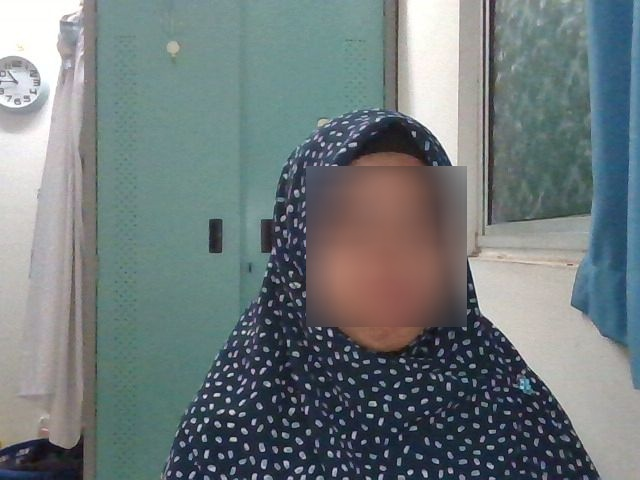

In [8]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))